<a href="https://colab.research.google.com/github/msrcoarreola/MachineLearning2/blob/main/kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# k-Nearest Neighbors (kNN)

## Fundamentos de la técnica

El clasificador k-Nearest Neighbors (kNN) es un método de aprendizaje supervisado para clasificación y regresión. Se basa en el principio de que instancias similares tienen etiquetas similares. Para clasificar un punto nuevo, el algoritmo busca sus k vecinos más cercanos y asigna la clase mayoritaria.

Es un método no paramétrico: no asume una forma funcional del modelo y almacena todos los datos. La complejidad se transfiere a la predicción.

## Modelo Matemático de la técnica

Distancia Euclidiana (más usada): para puntos x=(x1,...,xd) y y=(y1,...,yd):
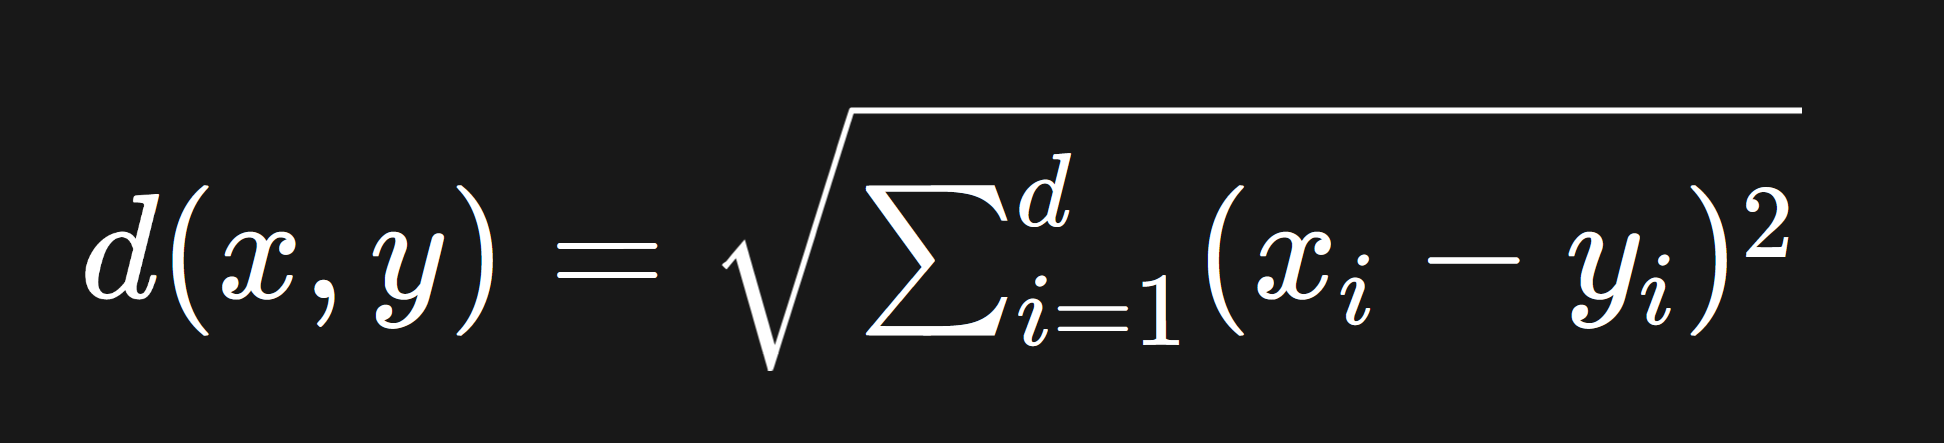

Regla de decisión (clasificación): se toman los k vecinos más cercanos de la muestra desconocida y se calcula la clase predominante (mayoría simple). Opcionalmente se puede hacer voto ponderado por 1/distancia.

Elección de k: k pequeño → más sensibilidad al ruido (alta varianza). k grande → decisiones más suaves (mayor sesgo).

## Librerías, clases y funciones

pandas: pd.read_csv, DataFrame — manipulación de datos.

numpy: arrays y operaciones numéricas (np.array, np.reshape).

matplotlib.pyplot: plt.scatter, plt.show — visualización.

seaborn (opcional): visualizaciones estadísticas.

sklearn.model_selection: train_test_split — dividir datos.

sklearn.preprocessing: StandardScaler — estandarizar features.

sklearn.feature_selection: SelectKBest, f_classif — selección de variables.

sklearn.neighbors: KNeighborsClassifier — implementación de kNN.

sklearn.metrics: confusion_matrix, accuracy_score, classification_report — evaluación.

## Importar librerías

In [45]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Cargar Iris como ejemplo de Dataset

In [46]:
#Dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')


print("Tamaño X:", X.shape)
X.head()

Tamaño X: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Análisis estadístico

In [47]:
# Estadísticas descriptivas
display(X.describe())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [48]:
# Recuento por clase
display(y.value_counts())

,count
target,
0,50
1,50
2,50


In [49]:
# Comprobar valores nulos
print("Valores nulos por columna:\n", X.isnull().sum())

Valores nulos por columna:
 sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64


## Gráfico de dispersión (Scatter) — pares de features

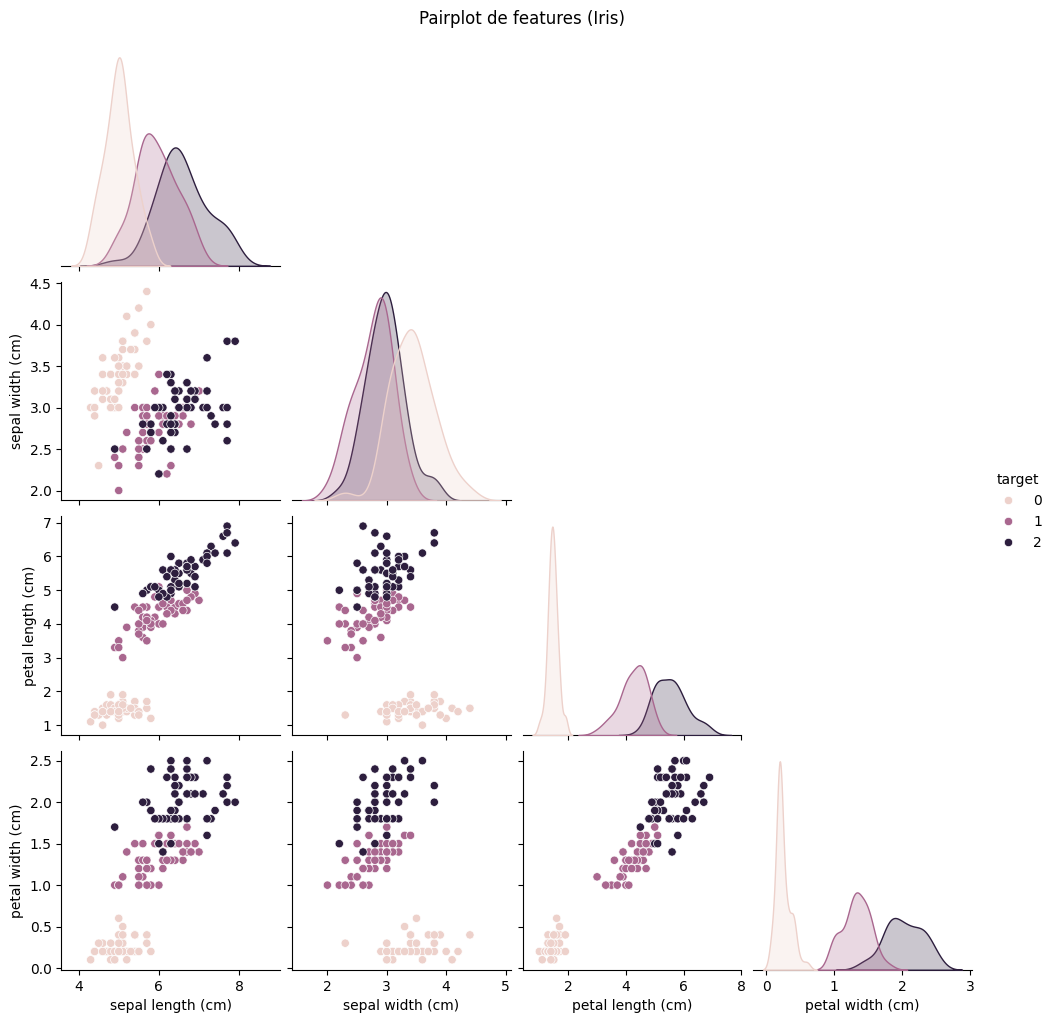

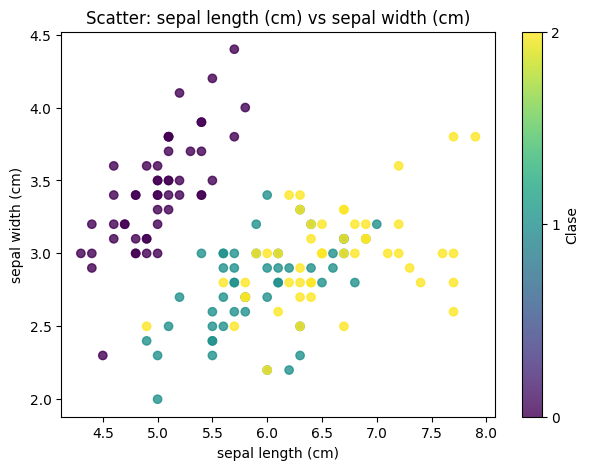

In [50]:
# Pairplot para ver relaciones y clusters
sns.pairplot(pd.concat([X, y], axis=1), hue='target', corner=True, vars=X.columns)
plt.suptitle('Pairplot de features (Iris)', y=1.02)
plt.show()


# Scatter simple entre dos variables (ejemplo)
plt.figure(figsize=(7,5))
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=y, cmap='viridis', alpha=0.8)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.title('Scatter: {} vs {}'.format(X.columns[0], X.columns[1]))
plt.colorbar(ticks=[0,1,2], label='Clase')
plt.show()

## Feature Engineering

### Selección de variables: SelectKBest con ANOVA (f_classif)

In [51]:
# Dividir train/test antes de selección para evitar data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [52]:
# Escalado (necesario para KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
# Selección de las 2 mejores variables
selector = SelectKBest(score_func=f_classif, k=2)
selector.fit(X_train_scaled, y_train)

SelectKBest(k=2)

In [54]:
mask = selector.get_support() # boolean mask de features seleccionadas
selected_features = X.columns[mask]
print('Selected features:', list(selected_features))

Selected features: ['petal length (cm)', 'petal width (cm)']


In [55]:
# Transformar
X_train_sel = selector.transform(X_train_scaled)
X_test_sel = selector.transform(X_test_scaled)

## Prediction — entrenar kNN y función de predicción

In [56]:
# Entrenar KNN
k = 5
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='minkowski', p=2)  # p=2 -> Euclidiana
knn.fit(X_train_sel, y_train)


# Función que recibe un patrón (lista/array) y devuelve la clase predicha
def predict_instance(model, scaler, selector, raw_instance, feature_names):
    """
    Función que recibe un patrón y devuelve la clase predicha
    """
    # Convertir a DataFrame con nombres correctos
    df = pd.DataFrame([raw_instance], columns=feature_names)

    # Escalar
    arr_scaled = scaler.transform(df)

    # Seleccionar features
    arr_sel = selector.transform(arr_scaled)

    # Predicción
    pred = model.predict(arr_sel)
    return pred[0]



# Ejemplo de uso con la primera muestra del test (antes de escalar)
sample_raw = X_test.iloc[0].values
feature_names = X.columns

predicted_class = predict_instance(knn, scaler, selector, sample_raw, feature_names)
print("Predicted:", predicted_class, "Actual:", int(y_test.iloc[0]))



Predicted: 0 Actual: 0


## Model evaluation

### Predicciones y matriz de confusión

Matriz de Confusión:
 [[12  0  0]
 [ 0 12  1]
 [ 0  1 12]]


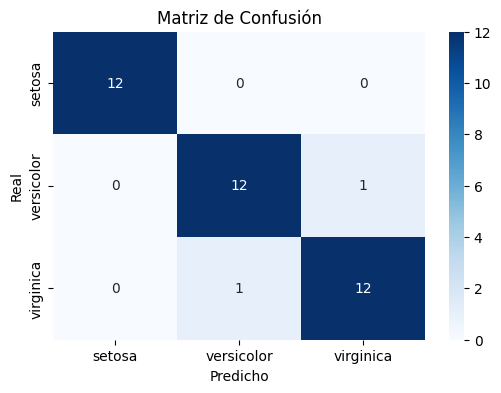

In [57]:
# Predicciones en test
y_pred = knn.predict(X_test_sel)


# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:\n', cm)


# Mostrar matriz con seaborn
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Accuary

In [58]:
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.9474


### Reporte de clasificación

In [59]:
report = classification_report(y_test, y_pred, target_names=iris.target_names)
print('Reporte de Clasificación:\n', report)

Reporte de Clasificación:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38

